# Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Module for conducting repeated-measure tests
from scipy.stats import wilcoxon
import statsmodels.api as sm
import pylab as py 

# Modules for author colloboration
import ast
import networkx as nx
import pickle

# Ignore warning messages (only) for display purpose
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [3]:
# Read dataframe
df = pd.read_csv("../database/preprocessed_content_analysis.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,first_name,middle_name,last_name,email,institution,award_year,award_amount,paper_title,journal,publication_year,...,citation_2019,citation_2020,citation_2021,citation_2022,citation_2023,citation_2024,tokenized_title,normalized_title,tokenized_abstract,normalized_abstract
0,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Effect of oxidation and geometrical dimensions...,Desalination,2011,...,13,5,10,5,7,1,"['Effect', 'of', 'oxidation', 'and', 'geometri...","['effect', 'oxidation', 'geometrical', 'dimens...","['This', 'study', 'reports', 'for', 'the', 'fi...","['study', 'report', 'time', 'use', 'oxidize', ..."
1,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Synthesis and biological evaluation of new pyr...,Molecules,2014,...,13,5,10,5,7,1,"['Synthesis', 'and', 'biological', 'evaluation...","['synthesis', 'biological', 'evaluation', 'new...","['A', 'selected', 'set', 'of', 'substituted', ...","['select', 'set', 'substituted', 'pyridone', '..."
2,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Synthesis of 6-Ethyl-1, 2, 9-trioxopyrrolo [3,...",Zeitschrift für Naturforschung B,2013,...,13,5,10,5,7,1,"['Synthesis', 'of', '6', 'Ethyl-1', '2', '9', ...","['synthesis', 'ethyl-1', 'trioxopyrrolo', 'f',...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
3,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Randa M. Al-As’ ada, Mustafa M. El-abadelaha, ...",Z. Naturforsch,2013,...,13,5,10,5,7,1,"['Randa', 'M.', 'Al', 'As', 'ada', 'Mustafa', ...","['randa', 'm.', 'al', 'ada', 'mustafa', 'm.', ...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
4,Leaf,NaN,Van Boven,vanboven@colorado.edu,university of colorado at boulder,2011,250000,Identifiable but not identical: Combining soci...,Journal of Consumer research,2012,...,868,1234,1132,1198,1222,179,"['Identifiable', 'but', 'not', 'identical', 'C...","['identifiable', 'identical', 'combine', 'soci...","['How', 'do', 'consumers', 'reconcile', 'confl...","['consumer', 'reconcile', 'conflicting', 'moti..."


In [4]:
# Add a column indicating whether the specific publication is before or after NSF award
# Here, we take publication year which is the same as award year as "before_award"
df["before_after_award"] = np.where(df["publication_year"] <= df["award_year"], "before_award", "after_award")

# Examine Collaboration Network

## Add collaboration-related information to the DataFrame

In [5]:
# Convert the string representation of a list
df['coauthors'] = df['coauthors'].apply(ast.literal_eval)

# Explode the DataFrame on the 'coauthors' column to get each collaboration on a separate row
exploded_df = df.explode('coauthors')

# Create tuples of (author's email, coauthor) for each row in the exploded DataFrame
collaborations = [(row['email'], coauthor) for _, row in exploded_df.iterrows() for coauthor in [row['coauthors']]]

In [6]:
# Create a DataFrame from the collaboration counts
collaborations_df = pd.DataFrame({
    'email': [email for email, _ in collaborations],
    'collaboration': collaborations,
})

In [7]:
collaborations_df

,email,collaboration
0,talalasad@earthlink.net,"(talalasad@earthlink.net, amjad h el-sheikh)"
1,talalasad@earthlink.net,"(talalasad@earthlink.net, yahya s al-degs)"
2,talalasad@earthlink.net,"(talalasad@earthlink.net, randa m al-as' ad)"
3,talalasad@earthlink.net,"(talalasad@earthlink.net, jamal a sweileh)"
4,talalasad@earthlink.net,"(talalasad@earthlink.net, ayman m saleh)"
...,...,...
636340,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, frank j m..."
636341,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, carl e re..."
636342,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, e wohl)"
636343,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, fj magill..."


## Build collaboration network for `before_award` and `right_after_award` periods

In [8]:
# Add year related information to the collaborations_df 
collaborations_df = pd.merge(df[['email', 'publication_year', 'before_after_award']], 
                             collaborations_df, on='email', how='inner')

In [9]:
# Store degree and closeness centrality measures for each year in Pickle (Python's object serialization)
yearly_degree_centrality_path = '../database/yearly_degree_centrality.pkl'
yearly_closeness_centrality_path = '../database/yearly_closeness_centrality.pkl'

if os.path.exists(yearly_degree_centrality_path) and os.path.exists(yearly_closeness_centrality_path):
    with open(yearly_degree_centrality_path, 'rb') as f:
        yearly_degree_centrality = pickle.load(f)
    
    with open(yearly_closeness_centrality_path, 'rb') as f:
        yearly_closeness_centrality = pickle.load(f)
    
else:
    # Initialize a dictionary to store yearly networks
    yearly_networks = {}

    for year, group in collaborations_df.groupby('publication_year'):
        G_year = nx.Graph()
        for _, row in group.iterrows():
            author_email, coauthor = row['collaboration']
            # Dynamically count the number of collaboration between two authors for each year
            if G_year.has_edge(author_email, coauthor):
                # If it exists, increment the weight by 1
                G_year[author_email][coauthor]['weight'] += 1
            else:
                # Otherwise, add a new edge with weight 1
                G_year.add_edge(author_email, coauthor, weight=1)
            
        yearly_networks[year] = G_year

    # Store degree and closness measures for each year
    yearly_degree_centrality = {}
    yearly_closeness_centrality = {}

    for year, network in yearly_networks.items():
        print(f"Begin deriving degree centrality measures for year {year}")
        yearly_degree_centrality[year] = nx.degree_centrality(network)

        print(f"Begin deriving closeness centrality measures for year {year}")
        yearly_closeness_centrality[year] = nx.closeness_centrality(network)

    # Save the centrality measures
    with open(yearly_degree_centrality_path, 'wb') as f:
        print("Save degree centrality measure")
        pickle.dump(yearly_degree_centrality, f)

    with open(yearly_closeness_centrality_path, 'wb') as f:
        print("Save closeness centrality measure")
        pickle.dump(yearly_closeness_centrality, f)

In [10]:
grouped_years = collaborations_df.groupby(by=['email', 'before_after_award'])['publication_year'].unique()

In [11]:
group_by_centrality = []

for (email, before_after_award), years in grouped_years.items():
    degree_values = []
    closeness_values = []

    for year in years:
        # Append degree centrality measure for each author (in each year)
        if year in yearly_degree_centrality and email in yearly_degree_centrality[year]:
            degree_values.append(yearly_degree_centrality[year].get(email, 0))

        # Append closeness centrality measure for each author (in each year)
        if year in yearly_closeness_centrality and email in yearly_closeness_centrality[year]:
            closeness_values.append(yearly_closeness_centrality[year].get(email, 0))

    if sum([i != 0 for i in degree_values]) > 0:
        average_degree = sum(degree_values) / sum([i != 0 for i in degree_values])
    else:
        average_degree = 0

    if sum([i != 0 for i in degree_values]) > 0:
        average_closeness = sum(closeness_values) / sum([i != 0 for i in closeness_values])
    else:
        average_closeness = 0

    # Append to data list
    group_by_centrality.append({
        'email': email,
        'before_after_award': before_after_award,
        'average_degree': average_degree,
        'average_closeness': average_closeness
    })

group_by_centrality = pd.DataFrame(group_by_centrality)

In [12]:
# Convert the dataframe about average_degree from long to wide format
average_degree_wide = group_by_centrality.drop('average_closeness', axis=1).pivot(\
    index='email', columns='before_after_award', values='average_degree')
average_degree_wide.columns.name = None
average_degree_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,0.000766,0.000756
a.satpute@northeastern.edu,0.003191,0.000867
aabrewer@uci.edu,0.000244,0.000378
aag6@psu.edu,0.000320,0.000579
aam72@georgetown.edu,0.000522,0.000435
...,...,...
zkrizan@iastate.edu,0.000267,0.000307
zoe.wool@rice.edu,0.000157,0.000111
zook@uky.edu,0.001188,0.001222


In [13]:
# Likewise, convert the dataframe about average_closeness from long to wide format
average_closeness_wide = group_by_centrality.drop('average_degree', axis=1).pivot(\
    index='email', columns='before_after_award', values='average_closeness')
average_closeness_wide.columns.name = None
average_closeness_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,0.160031,0.152599
a.satpute@northeastern.edu,0.177090,0.209292
aabrewer@uci.edu,0.174160,0.157203
aag6@psu.edu,0.000320,0.000579
aam72@georgetown.edu,0.192232,0.187448
...,...,...
zkrizan@iastate.edu,0.178573,0.177194
zoe.wool@rice.edu,0.000157,0.105947
zook@uky.edu,0.179656,0.175523


## Repeated measure test to test before and right after award difference in degree centrality

In [14]:
# Filter out na values
average_degree_wide.dropna(inplace=True)

In [15]:
# Calculate difference in mean_cosine_distance
average_degree_wide['mean_diff'] = average_degree_wide['after_award'] - average_degree_wide['before_award']

In [16]:
average_degree_wide['mean_diff']

email
00t0holtgrav@bsu.edu                0.000011
a.satpute@northeastern.edu          0.002324
aabrewer@uci.edu                   -0.000134
aag6@psu.edu                       -0.000258
aam72@georgetown.edu                0.000087
                                      ...   
zkrizan@iastate.edu                -0.000040
zoe.wool@rice.edu                   0.000047
zook@uky.edu                       -0.000033
zulu@msu.edu                       -0.000111
zygmunt.frajzyngier@colorado.edu   -0.000098
Name: mean_diff, Length: 1993, dtype: float64

In [17]:
average_degree_wide.apply(np.mean, axis=0)

after_award     0.001161
before_award    0.001121
mean_diff       0.000040
dtype: float64

Text(0.5, 1.0, 'Q-Q Plot of Difference in Entropy of Cosine Distance')

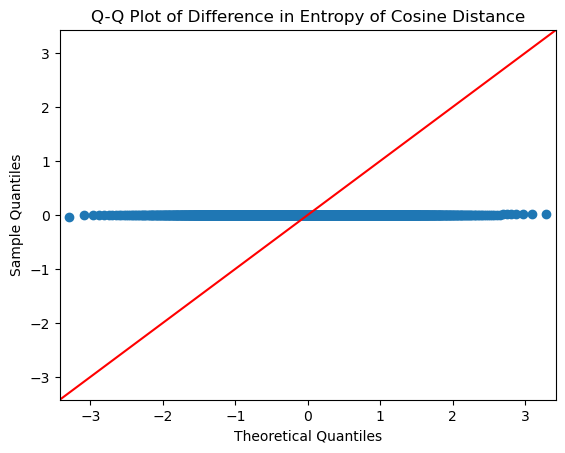

In [18]:
sm.qqplot(average_degree_wide['mean_diff'], line ='45') 
plt.title('Q-Q Plot of Difference in Entropy of Cosine Distance')

In [19]:
wilcoxon(average_degree_wide['mean_diff'])

WilcoxonResult(statistic=952724.0, pvalue=0.1211968700493568)

In [21]:
# Define a function using bootstrapping to calculate confidence interval of mean difference
def bootstrap_effect_size(group1, group2, n_bootstrap=10000):
    np.random.seed(42)
    bootstrapped_means_diff = []

    for _ in range(n_bootstrap):
        boot_group1 = np.random.choice(group1, size=len(group1), replace=True)
        boot_group2 = np.random.choice(group2, size=len(group2), replace=True)
        bootstrapped_means_diff.append(boot_group2.mean() - boot_group1.mean())

    # Calculate the 95% confidence interval
    lower, upper = np.percentile(bootstrapped_means_diff, [2.5, 97.5])
    
    return np.mean(bootstrapped_means_diff), lower, upper

In [22]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    average_degree_wide['before_award'],
    average_degree_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): 3.918277698752575e-05, 95% CI: [-9.939896866246067e-05, 0.00017193616478637744]


## Repeated measure test to test before and right after award difference in closeness centrality

In [23]:
# Filter out na values
average_closeness_wide.dropna(inplace=True)

In [24]:
# Calculate difference in mean_cosine_distance
average_closeness_wide['mean_diff'] = average_closeness_wide['after_award'] - average_closeness_wide['before_award']

In [25]:
average_closeness_wide.apply(np.mean, axis=0)

after_award     0.168344
before_award    0.167566
mean_diff       0.000777
dtype: float64

In [26]:
wilcoxon(average_closeness_wide['mean_diff'])

WilcoxonResult(statistic=815192.0, pvalue=4.968823805141583e-12)

In [27]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    average_closeness_wide['before_award'],
    average_closeness_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): 0.000762184045084453, 95% CI: [-0.002159767249041927, 0.0036988562429706084]
